In [2]:
import os
import xml.etree.ElementTree as ET
from natsort import natsorted
import pandas as pd
from PIL import Image
import numpy as np
import requests
from zipfile import ZipFile
from io import BytesIO
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import random
from six.moves import xrange
import collections
import string

In [3]:

def download_dataset(save_path):
    r = requests.get("http://cimalab.unal.edu.co/applications/thyroid/thyroid.zip")
    print("Downloading...")
    z = ZipFile(BytesIO(r.content))
    z.extractall(save_path)
    print("Completed...")

# XML and Jpeg
def to_dataframe(path):
    dirs=natsorted(os.listdir(path))
    xml_list=[]
    img_list=[]
    for i in range(len(dirs)):
        if '.xml' in dirs[i]:
            xml_list.append(dirs[i])
        if not '.xml'  in dirs[i]:
            img_list.append(dirs[i])
    xml_list=natsorted(xml_list)
    img_list=natsorted(img_list)
    tirads=[]
    for j in range(len(xml_list)):
        tree = ET.parse(path+'/'+xml_list[j])
        a=tree.findall("./tirads")
        if a[-1].text!=None:
            case=[xml_list[j],a[-1].text]
            tirads.append(case)
    data=[]
    for k in range(len(tirads)):
        xml=tirads[k][0][:-4]
        for z in range(len(img_list)):
            if xml+'_1.jpg'==img_list[z] or xml+'_2.jpg'==img_list[z] or xml+'_3.jpg'==img_list[z]:
                m=[img_list[z],tirads[k][1]]
                data.append(m)

    df = pd.DataFrame(data,columns =['Jpeg_Name', 'Tirads'])
    return df

#Cropp Function
def croping(img,x, y, w, h):
    if abs(w)<abs(h):
        img2=np.zeros([h,h])
        img2[:,h-w:h]=img[y:y+h, x:x+w]
    if abs(h)<abs(w):
        img2=np.zeros([w,w])
        img2[w-h:w,:]=img[y:y+h, x:x+w]
    else:
        return img
    return img2

def convert_one_channel(img):
    #if some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

#Remove Fill area from Image and Resizeing
def crop_resize(path,resize_shape):
    img=plt.imread(path)
    img=convert_one_channel(np.asarray(img))
    kernel =( np.ones((5,5), dtype=np.float32))
    ret,thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    thresh = thresh.astype(np.uint8)
    a1,b1=thresh.shape
    thresh=cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel,iterations=3 )
    thresh=cv2.erode(thresh,kernel,iterations =5)
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c_area=np.zeros([len(contours)])
    for i in range(len(contours)):
        c_area[i]= cv2.contourArea(contours[i])
    cnts=contours[np.argmax(c_area)]
    x, y, w, h = cv2.boundingRect(cnts)
    roi = croping(img, x, y, w, h)
    roi=cv2.resize(roi,(resize_shape),interpolation=cv2.INTER_LANCZOS4)
    return roi


# TO Data Matrix
def to_imgmatrix(resize_shape,path,df):
    path=path+'/'
    images=crop_resize(path+df["Jpeg_Name"][0],resize_shape)
    for i in range (1,len(df["Jpeg_Name"])):
        img=crop_resize(path+df["Jpeg_Name"][i],resize_shape)
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(df["Jpeg_Name"]),resize_shape[0],resize_shape[1],1))
    return images

def prepare_data(path,resize_shape):
    df=to_dataframe(path)
    data=to_imgmatrix(resize_shape,path,df)
    return df,data


# We need numeric category
def to_categoricalmatrix(df):
    #There are little categories, so i handled manually
    Y=np.zeros([len(df["Tirads"])])
    for i in range(len(df["Tirads"])):
        if df["Tirads"][i]=="2":
          Y[i]=0
        if df["Tirads"][i]=="3":
          Y[i]=1
        if df["Tirads"][i]=="4a":
          Y[i]=2
        if df["Tirads"][i]=="4b":
          Y[i]=3
        if df["Tirads"][i]=="4c":
          Y[i]=4
        if df["Tirads"][i]=="5":
          Y[i]=5
    return Y


In [4]:
download_dataset("/content/Data")

Downloading...
Completed...


In [5]:
df,data=prepare_data("/content/Data",(256,256))

In [6]:
df.head()

,Jpeg_Name,Tirads
0,2_1.jpg,2
1,3_1.jpg,4a
2,4_1.jpg,4a
3,5_1.jpg,5
4,6_1.jpg,4b


In [7]:
y = to_categoricalmatrix(df)

y = tf.keras.utils.to_categorical(y)


In [8]:
#normalize function
def normalize(data):
  for i in range(len(data)):
    data[i,:,:,:]=data[i,:,:,:]*(1/np.max(data[i,:,:,:]))
  return np.float32(data)

# we need noormalize to images
x=normalize(data)

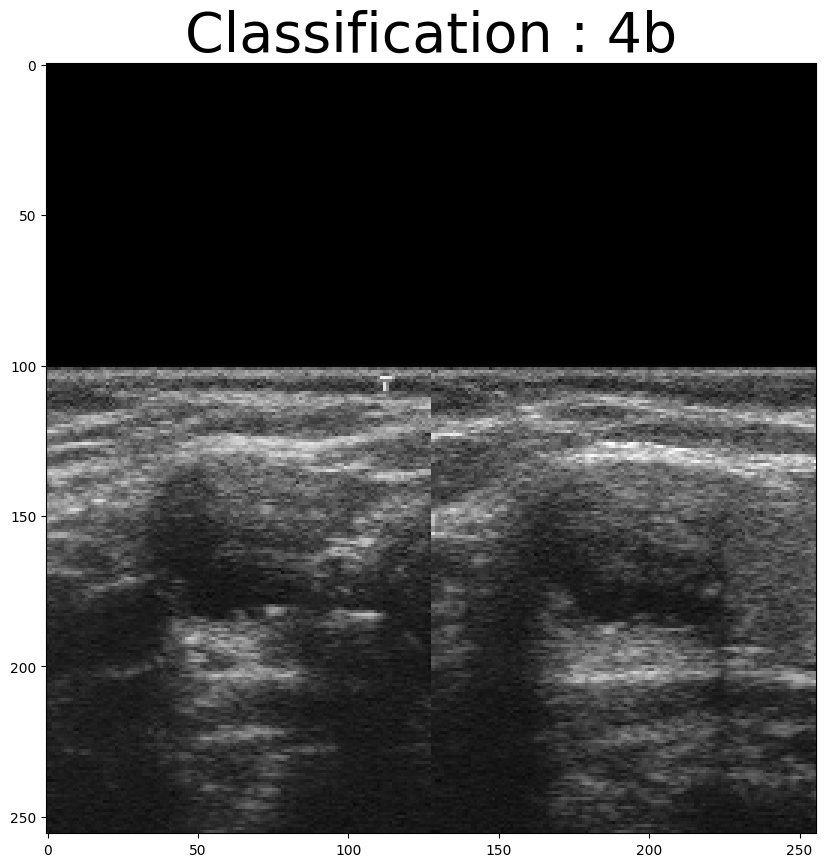

In [9]:
random_number2=random. randint(0,len(df["Tirads"]))
plt.figure(figsize = (20,10))
tit2 = "Classification : " + str(df["Tirads"][random_number2])
plt.title(tit2,fontsize = 40)
plt.imshow(x[random_number2,:,:,0],cmap="gray")

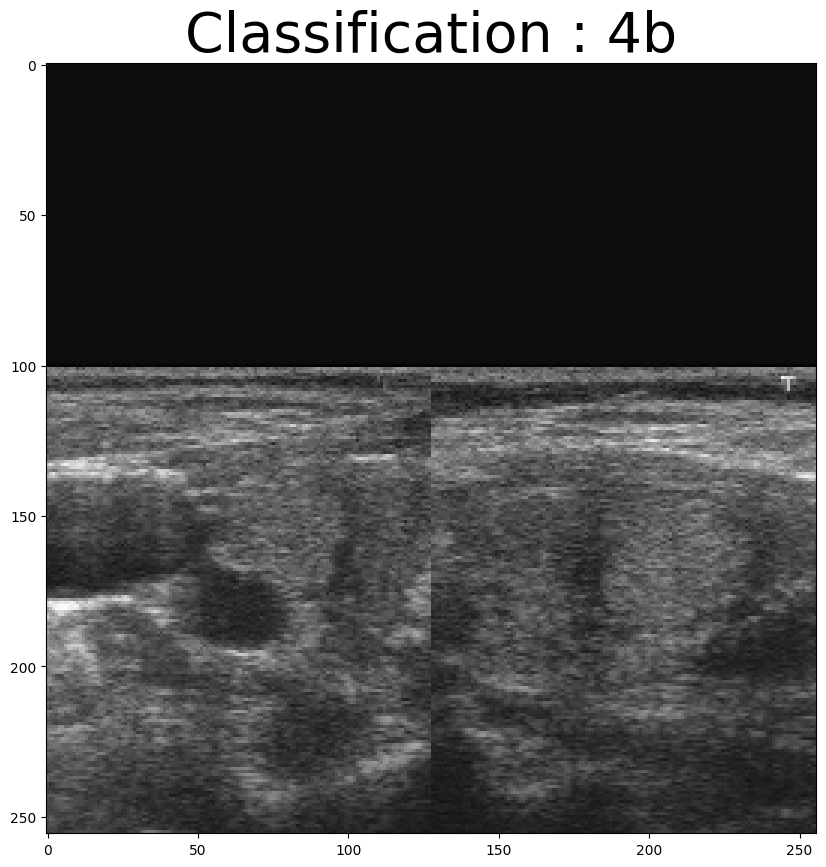

In [10]:
import random
random_number=random. randint(0,len(df["Tirads"]))
plt.figure(figsize = (20,10))
tit2 = "Classification : " + str(df["Tirads"][random_number2])
plt.title(tit2,fontsize = 40)
plt.imshow(x[random_number,:,:,0],cmap="gray")